# Generating in silico data

In [1]:
from yeastdnnexplorer.probability_models.generate_data import (generate_gene_population, 
                                                               generate_binding_effects,
                                                               generate_pvalues,
                                                               generate_perturbation_effects)

import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)  # For CPU
torch.cuda.manual_seed_all(42)  # For all CUDA devices


## Step 1:

The first step is to generate a gene population, or set of gene populations.
A gene population is simply a class that stores a 1D tensor called `labels`.
`labels` is a boolean vector where 1 means the gene is part of the signal group
(a gene which is both bound and responsive to the TF) while 0 means the gene is
part of the background or noise group. The length of `labels` is the number of
genes in the population, and the index should be considered the unique gene
identifier. In other words, the indicies should never change.

In [2]:
n_genes = 1000
signal = [0.1, 0.15, 0.2, 0.25, 0.3]
n_sample = [1, 1, 2, 2, 4]

# this will be a list of length 10 with a GenePopulation object in each element
gene_populations_list = []
for signal_proportion, n_draws in zip(signal, n_sample):
    for _ in range(n_draws):
        gene_populations_list.append(generate_gene_population(n_genes, signal_proportion))


## Step 2:

The second step is to generate binding data from the gene population(s).

In [3]:
# Generate binding data for each gene population
binding_effect_list = [generate_binding_effects(gene_population)
                     for gene_population in gene_populations_list]


# Calculate p-values for binding data
binding_pvalue_list = [generate_pvalues(binding_data) for binding_data in binding_effect_list]

binding_data_combined = [torch.stack((gene_population.labels, binding_effect, binding_pval), dim=1)
                         for gene_population, binding_effect, binding_pval
                         in zip (gene_populations_list, binding_effect_list, binding_pvalue_list)]

# Stack along a new dimension (dim=1) to create a tensor of shape [num_genes, num_TFs, 3]
binding_data_tensor = torch.stack(binding_data_combined, dim=1)

# Verify the shape
print("Shape of the binding data tensor:", binding_data_tensor.shape)


Shape of the binding data tensor: torch.Size([1000, 10, 3])


## Step 3: Generate perturbation data.

Note that you can optionally use the binding enrichment data across one or more
TFs to probabilistically increase the chance of a larger perturbation effect.

In [4]:
# note that you could use different settings for the perturbation effects
# for each TF, or possibly use the n_samples vector from step 1. You also have
# the option of using all or some of the TFs to conditionally affect the
# binding score. See `generate_perturbation_effects()` in the help or the
# documentation for more details.
perturbation_effects_list = [generate_perturbation_effects(binding_data_tensor, tf_index=tf_index)
                             for tf_index in range(sum(n_sample))]

perturbation_pvalue_list = [generate_pvalues(perturbation_effects)
                            for perturbation_effects in perturbation_effects_list]



## Step 4: Assemble

The final step is to assemble the data into a single tensor. Here is one way.
The order of the matrix in the last dimension is:

1. signal/noise label
1. binding effect
1. binding pvalue
1. perturbation effect
1. perturbation pvalue

In [5]:
# Convert lists to tensors if they are not already
perturbation_effects_tensor = torch.stack(perturbation_effects_list, dim=1)
perturbation_pvalues_tensor = torch.stack(perturbation_pvalue_list, dim=1)

# Ensure perturbation data is reshaped to match [n_genes, n_tfs]
# This step might need adjustment based on the actual shapes of your tensors.
perturbation_effects_tensor = perturbation_effects_tensor.unsqueeze(-1)  # Adds an extra dimension for concatenation
perturbation_pvalues_tensor = perturbation_pvalues_tensor.unsqueeze(-1)  # Adds an extra dimension for concatenation

# Concatenate along the last dimension to form a [n_genes, n_tfs, 5] tensor
final_data_tensor = torch.cat((binding_data_tensor, perturbation_effects_tensor, perturbation_pvalues_tensor), dim=2)

# Verify the shape
print("Shape of the final data tensor:", final_data_tensor.shape)

Shape of the final data tensor: torch.Size([1000, 10, 5])


As an aside, I choose to structure the data this way by looking at the
result of strides, which describes how the data is stored in memory:

In [6]:
tensor_continuous = torch.empty(100, 1000, 3)
strides_continuous = tensor_continuous.stride()
print(strides_continuous)


tensor_continuous = torch.empty(1000, 100, 3)
strides_continuous = tensor_continuous.stride()
print(strides_continuous)

(3000, 3, 1)
(300, 3, 1)


## Sanity checks

Ensure that the generated data matches expectations.

### The signal/noise ratios should match exactly the initial signal ratio

In [7]:
tolerance = 1e-5
are_equal = torch.isclose(
    torch.sum(final_data_tensor[:, :, 0] == 1, axis=0),
    torch.tensor([val * n_genes for val, count in zip(signal, n_sample) for _ in range(count)],
                 dtype=torch.long),
    atol=tolerance)

print(f"signal/nosie ratio is correct: {are_equal.all()}")

signal/nosie ratio is correct: True


### Binding effect distributions should match expectations




In [8]:
labels = final_data_tensor[:, :, 0].flatten()
noise_binding = final_data_tensor[:, :, 1].flatten()[labels == 0]
signal_binding = final_data_tensor[:, :, 1].flatten()[labels == 1]

print(f"The noise binding max is {noise_binding.max()} and the min is {noise_binding.min()}")
print(f"the noise min is {noise_binding.min()}")
print(f"the noise mean is {noise_binding.mean()} and the std is {noise_binding.std()}")
print(f"The signal binding max is {signal_binding.max()} and the min is {signal_binding.min()}")
print(f"the signal min is {signal_binding.min()}")
print(f"the signal mean is {signal_binding.mean()} and the std is {signal_binding.std()}")

The noise binding max is 13.157892227172852 and the min is 0.0
the noise min is 0.0
the noise mean is 0.3589712679386139 and the std is 1.1559306383132935
The signal binding max is 78.94734954833984 and the min is 0.1315789520740509
the signal min is 0.1315789520740509
the signal mean is 2.4840002059936523 and the std is 6.374814510345459


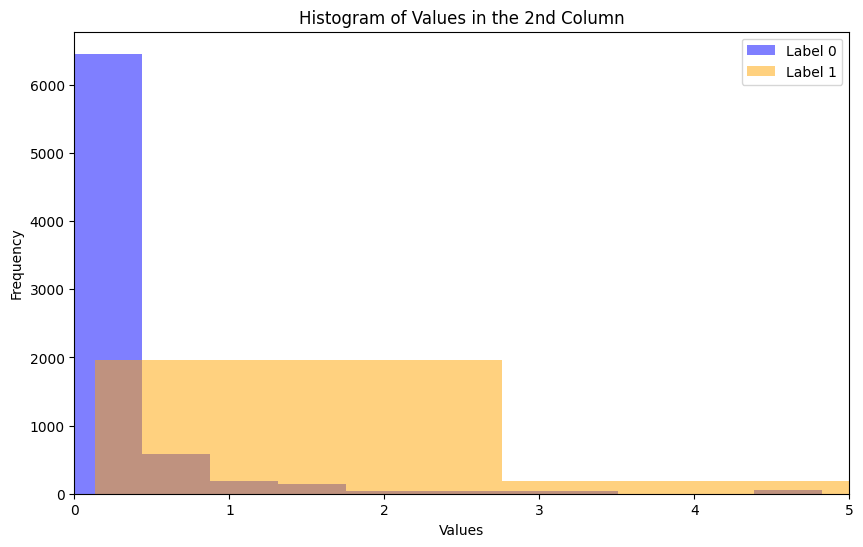

In [9]:

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(noise_binding, bins=30, alpha=0.5, label='Label 0', color='blue')
plt.hist(signal_binding, bins=30, alpha=0.5, label='Label 1', color='orange')
plt.xlim(0,5)
plt.title('Histogram of Values in the 2nd Column')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Perturbation effect distribtuions should match expectations

In [10]:
noise_perturbation = final_data_tensor[:, :, 3].flatten()[labels == 0]
signal_perturbation = final_data_tensor[:, :, 3].flatten()[labels == 1]

print(f"The noise binding max is {noise_perturbation.max()} and the min is {noise_perturbation.min()}")
print(f"the noise min is {noise_perturbation.min()}")
print(f"the noise mean is {noise_perturbation.mean()} and the std is {noise_perturbation.std()}")
print(f"The signal binding max is {signal_perturbation.max()} and the min is {signal_perturbation.min()}")
print(f"the signal min is {signal_perturbation.min()}")
print(f"the signal mean is {signal_perturbation.mean()} and the std is {signal_perturbation.std()}")

The noise binding max is 3.423511505126953 and the min is -3.506139039993286
the noise min is -3.506139039993286
the noise mean is 0.010617651976644993 and the std is 0.988001823425293
The signal binding max is 6.107701301574707 and the min is -6.406703948974609
the signal min is -6.406703948974609
the signal mean is -0.011303802020847797 and the std is 3.136451482772827


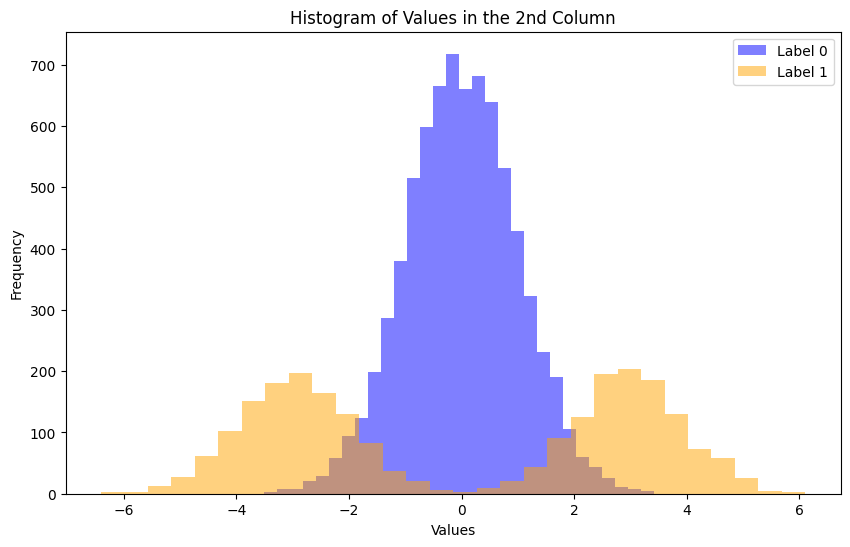

In [11]:
# Plotting
plt.figure(figsize=(10, 6))
plt.hist(noise_perturbation, bins=30, alpha=0.5, label='Label 0', color='blue')
plt.hist(signal_perturbation, bins=30, alpha=0.5, label='Label 1', color='orange')
plt.title('Histogram of Values in the 2nd Column')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### The binding effects should be positively correlated with the perturbaiton effects

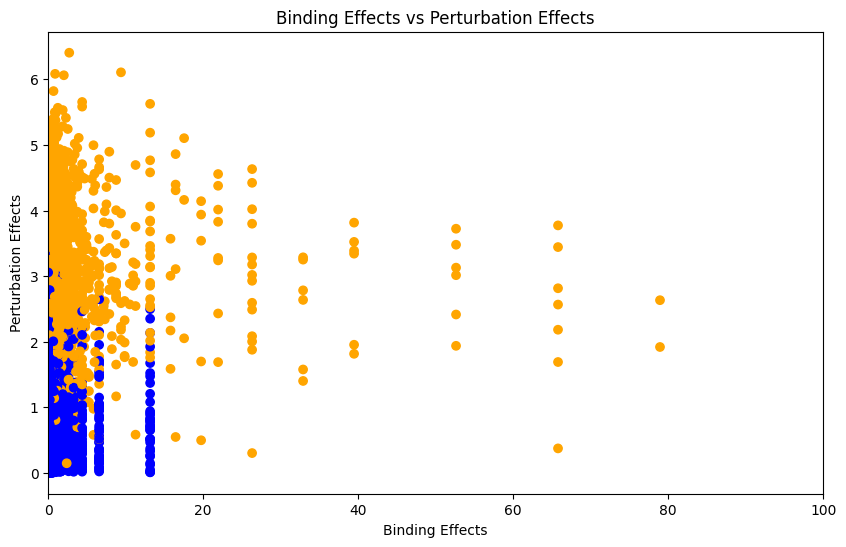

In [12]:
# plot the binding effects vs the perturbation effects
# color the points by the label
# make sure the labels are categorical
# label 0 should be blue while label 1 should be orange

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(final_data_tensor[:, :, 1].flatten(), final_data_tensor[:, :, 3].flatten().abs(), c=['blue' if x == 0 else 'orange' for x in labels])
plt.title('Binding Effects vs Perturbation Effects')
plt.xlabel('Binding Effects')
plt.ylabel('Perturbation Effects')
plt.xlim(0,100)
plt.show()

### Re-generate data with an explicit relationship between a give TF's binding and perturbation effects

In [20]:
# in this case, select the TF binding data that corresponds with the effect data
# which we wish to produce. use the .unsqueeze(1) method to add the TF dimension
# after selecting the TF
perturbation_effects_tf_influenced = [generate_perturbation_effects(binding_data_tensor[:,tf_index,:].unsqueeze(1), tf_index=0, max_mean_adjustment=10.0)
                             for tf_index in range(sum(n_sample))]

perturbation_pvalue_tf_influenced = [generate_pvalues(perturbation_effects)
                            for perturbation_effects in perturbation_effects_list]

perturbation_effects_tensor_tf_influened = torch.stack(perturbation_effects_tf_influenced, dim=1).unsqueeze(-1)
perturbation_pvalues_tensor_tf_influenced = torch.stack(perturbation_pvalue_tf_influenced, dim=1).unsqueeze(-1)

# Concatenate along the last dimension to form a [n_genes, n_tfs, 5] tensor
final_data_tensor_tf_influenced = torch.cat(
    (binding_data_tensor,
     perturbation_effects_tensor_tf_influened,
     perturbation_pvalues_tensor_tf_influenced), 
    dim=2)

# Verify the shape
print("Shape of the final data tensor:", final_data_tensor.shape)

Shape of the final data tensor: torch.Size([1000, 10, 5])


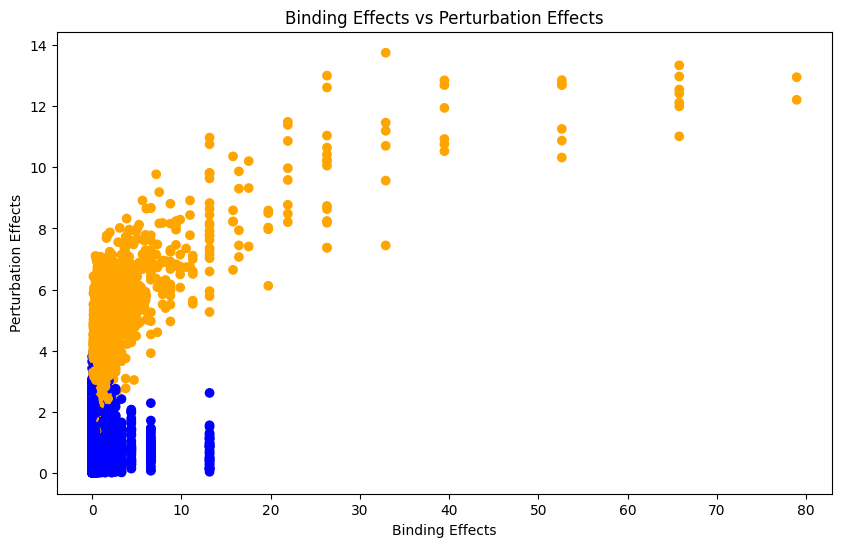

In [21]:
# Plotting. Note that the 'noise' group effects are still range from 0 to 3

plt.figure(figsize=(10, 6))
plt.scatter(final_data_tensor_tf_influenced[:, :, 1].flatten(), final_data_tensor_tf_influenced[:, :, 3].flatten().abs(), c=['blue' if x == 0 else 'orange' for x in labels])
plt.title('Binding Effects vs Perturbation Effects')
plt.xlabel('Binding Effects')
plt.ylabel('Perturbation Effects')
plt.show()